# Fast Machine Unlearning Without Retraining Through Selective Synaptic Dampening - Jack Foster et al. AAAI 2024

## Fisher Information Matrix
Fisher Information Matrix measures the amount of information that an observable random variable carries about unknown parameters of a model that determine the probability distribution of that variable.
Example: Let’s say we have a random variable  𝑋 and X drawn from a normal distribution with μ and σ. Here, σ is known and μ is unknown. We could pass the samples and compute FIM which would tell how much the data influences the unknown parameter.

#### Significance:
 - A higher Fisher information implies you can estimate the parameter more precisely from your data.

 - A lower Fisher information means your data isn't as informative about that parameter — it would take more samples to estimate it accurately



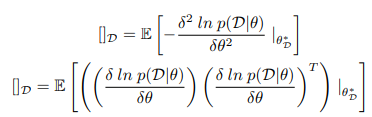

### Experimented Methods:
- Naive Pruning
- Binary Update rule with hyperparameter lambda based pruning
- Dampening
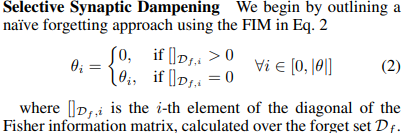

In [43]:
from torchvision.datasets import CIFAR100
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torch.optim import Adam
from tqdm import tqdm
from torch.nn import functional as F
import torch

### Loading Dataset

In [14]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

class customCIFAR100(CIFAR100):
    def __init__(self, root, train, download, transform):
        super().__init__(root = root, train = train, download = download, transform = transform)
        self.coarse_map = {
            0:[4, 30, 55, 72, 95],
            1:[1, 32, 67, 73, 91],
            2:[54, 62, 70, 82, 92],
            3:[9, 10, 16, 28, 61],
            4:[0, 51, 53, 57, 83],
            5:[22, 39, 40, 86, 87],
            6:[5, 20, 25, 84, 94],
            7:[6, 7, 14, 18, 24],
            8:[3, 42, 43, 88, 97],
            9:[12, 17, 37, 68, 76],
            10:[23, 33, 49, 60, 71],
            11:[15, 19, 21, 31, 38],
            12:[34, 63, 64, 66, 75],
            13:[26, 45, 77, 79, 99],
            14:[2, 11, 35, 46, 98],
            15:[27, 29, 44, 78, 93],
            16:[36, 50, 65, 74, 80],
            17:[47, 52, 56, 59, 96],
            18:[8, 13, 48, 58, 90],
            19:[41, 69, 81, 85, 89]
        }
    def __getitem__(self,index):
        x, y = super().__getitem__(index)
        coarse_y = None
        for i in range(20):
            for j in self.coarse_map[i]:
                if y == j:
                    coarse_y = i
                    break
            if coarse_y != None:
                break
        if coarse_y == None:
            print(y)
            assert coarse_y != None
        return x, y, coarse_y


In [15]:
train_ds = customCIFAR100(".",train=True,download=True, transform=transform_train)
test_ds = customCIFAR100(".",train=False,download=True, transform=transform_test)

In [16]:
train_dl = DataLoader(train_ds,batch_size=256,shuffle=True)
test_dl = DataLoader(test_ds,batch_size=256,shuffle=True)

### Training the Model

In [13]:
class ResNet18(nn.Module):
    def __init__(self,num_classes,pretrained):
        super().__init__()
        base = resnet18(pretrained=pretrained)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,num_classes)

    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)

In [49]:
device = 'cuda'
model = ResNet18(num_classes=20,pretrained=True)
model.to(device)
print("Loaded a pretrained a model.")

Loaded a pretrained a model.


In [50]:
optimizer = Adam(model.parameters(),lr=0.001)

In [51]:
def evaluate(model,valid_dl,device):
    model.eval()
    correct = 0
    total = 0
    track_loss = []
    for x,_,y in valid_dl:
        x,y = x.to(device),y.to(device)
        with torch.no_grad():
            predictions = model(x)
            loss = F.cross_entropy(predictions,y)
            track_loss.append(loss.item())
            _,preds = torch.max(predictions,dim=1)
            correct += (preds == y).sum().item()
            total +=  y.size(0)

    avg_loss = sum(track_loss)/len(track_loss)
    acc = correct/total

    return avg_loss,acc

In [52]:
def train(model,train_dl,valid_dl,epochs,device):
    for epoch in tqdm(range(epochs)):
        batch_loss = []
        model.train()
        for batch_idx,(x,_,y) in enumerate(train_dl):
            x,y = x.to(device),y.to(device)
            predictions = model(x) #logits
            loss = F.cross_entropy(predictions,y) #calculate loss
            batch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        val_loss,val_acc = evaluate(model,valid_dl,device)
        print(f"Epoch: {epoch}| Train Loss: {sum(batch_loss)/len(batch_loss):.4f}|Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

In [53]:
epochs = 5
train(model,train_dl,test_dl,epochs,device)

 20%|██        | 1/5 [01:54<07:38, 114.62s/it]

Epoch: 0| Train Loss: 1.0657|Val Loss: 0.8736 | Val Accuracy: 0.7163


 40%|████      | 2/5 [03:49<05:43, 114.50s/it]

Epoch: 1| Train Loss: 0.6171|Val Loss: 0.6898 | Val Accuracy: 0.7748


 60%|██████    | 3/5 [05:43<03:49, 114.61s/it]

Epoch: 2| Train Loss: 0.4180|Val Loss: 0.7453 | Val Accuracy: 0.7785


 80%|████████  | 4/5 [07:38<01:54, 114.52s/it]

Epoch: 3| Train Loss: 0.2825|Val Loss: 0.8506 | Val Accuracy: 0.7580


100%|██████████| 5/5 [09:32<00:00, 114.54s/it]

Epoch: 4| Train Loss: 0.2058|Val Loss: 0.7401 | Val Accuracy: 0.7932


### Creating the forget set
Gonna Unlearn Rocket Class [69]

In [54]:
from torch.utils.data import Subset
import random

In [55]:
#69->rocket class
indices_to_retain_train = [i for i, (_,label,_) in enumerate(train_ds) if label!=69]
indices_to_forget_train = [i for i, (_,label,_) in enumerate(train_ds) if label==69]

indices_to_retain_test = [i for i, (_,label,_) in enumerate(test_ds) if label!=69]
indices_to_forget_test = [i for i, (_,label,_) in enumerate(test_ds) if label==69]


retain_train_ds = Subset(train_ds,indices_to_retain_train)
forget_train_ds = Subset(train_ds,indices_to_forget_train)

retain_test_ds = Subset(test_ds,indices_to_retain_test)
forget_test_ds = Subset(test_ds,indices_to_forget_test)


retain_test_dl = DataLoader(retain_test_ds,batch_size=256,shuffle=True)
forget_test_dl = DataLoader(forget_test_ds,batch_size=256,shuffle=True)

retain_train_dl = DataLoader(retain_train_ds,batch_size=256,shuffle=True)
forget_train_dl = DataLoader(forget_train_ds,batch_size=256,shuffle=True)

In [57]:
evaluate(model,retain_test_dl,device #Evaluating the trained model on retain test set (loss,accuracy)

(0.7489036306356772, 0.7933333333333333)

In [59]:
evaluate(model,forget_test_dl,device) #Evaluating the trained model on forget test set (loss,accuracy)

(0.6617483496665955, 0.78)

In [65]:
torch.save(model.state_dict(), "Resnet18_CIFAR100_5_Epochs.pt")

### Calculating Fisher Information Matrix

In [89]:
unlearning_model = ResNet18(num_classes = 20, pretrained = True).to('cuda')
unlearning_model.load_state_dict(torch.load("/kaggle/working/Resnet18_CIFAR100_5_Epochs.pt", map_location='cuda'))

<All keys matched successfully>

In [90]:
import time

In [91]:
def calculate_fisher_information_matrix(model, dataloader, device):
    fisher_diagonal = {n: torch.zeros_like(p) for n, p in model.named_parameters()}
    model.eval()

    for x, _, y in dataloader:
        x, y = x.to(device), y.to(device)
        
        output = model(x)
        log_probs = torch.log_softmax(output, dim=1)
        
        # Choose the log-prob of the true class for each sample
        selected_log_probs = log_probs[range(len(y)), y]
        
        # Compute mean negative log-likelihood
        loss = -selected_log_probs.mean()
        
        # Zero out gradients before backward
        model.zero_grad()
        loss.backward()
        
        # Accumulate squared gradients (diagonal Fisher estimate)
        for n, p in model.named_parameters():
            if p.grad is not None:
                fisher_diagonal[n] += p.grad.data ** 2

    '''# Normalise Fisher over number of batches 
    for n in fisher_diagonal:
        fisher_diagonal[n] /= len(dataloader)'''
        
    return fisher_diagonal

In [92]:
start = time.time()
forget_fisher_diagonal = calculate_fisher_information_matrix(unlearning_model,forget_train_dl,device)
end = time.time()

print("Time Taken for computation:",end-start)

Time Taken for computation: 0.9477856159210205


In [93]:
start = time.time()
retain_fisher_diagonal = calculate_fisher_information_matrix(unlearning_model,retain_train_dl,device)
end = time.time()

print("Time Taken for computation:",end-start)

Time Taken for computation: 92.98641443252563


### Naive Pruning
 - Computing the entire FIM is expensive, hence we compute only the diagonal elements of FIM. 
 -  Naive approach outlied is to remove all the weights that has FIM score more for D_forget than FIM score for D_retain.
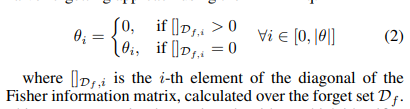

In [99]:
unlearning_model = ResNet18(num_classes = 20, pretrained = True).to('cuda')
unlearning_model.load_state_dict(torch.load("/kaggle/working/Resnet18_CIFAR100_5_Epochs.pt", map_location='cuda'))

<All keys matched successfully>

In [100]:
total_weights = 0
zeroed_weights = 0

with torch.no_grad():
    for name, param in unlearning_model.named_parameters():
        forget_fisher = forget_fisher_diagonal.get(name)
        retain_fisher = retain_fisher_diagonal.get(name)
        if forget_fisher is None or retain_fisher is None:
            continue
        
        mask = forget_fisher > 0
        
        # Count total and zeroed weights for this parameter
        total_weights += param.numel()
        zeroed_weights += mask.sum().item()
        
        param.data[mask] = 0.0

fraction_zeroed = zeroed_weights / total_weights
print(f"Fraction of weights zeroed out: {fraction_zeroed:.4f}")

Fraction of weights zeroed out: 0.9995


In [101]:
evaluate(unlearning_model,retain_test_dl,device) #Evaluating the Unlearnt model on retain test set (loss,accuracy)

(2.9957327842712402, 0.050505050505050504)

In [102]:
evaluate(unlearning_model,forget_test_dl,device) #Evaluating the Unlearnt model on forget test set (loss,accuracy)

(2.995731830596924, 0.0)

#### Inference: Catastrophic Forgetting as the fraction of parameters set to 0 as close to 0.99% of enitre params

### Binary Update Rule with hyperparameter lambda
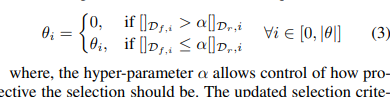

- As per the paper guideline setting the lambda to be 1
- ps: utilizing the previously computed FIM values. since same model

In [103]:
unlearning_model = ResNet18(num_classes = 20, pretrained = True).to('cuda')
unlearning_model.load_state_dict(torch.load("/kaggle/working/Resnet18_CIFAR100_5_Epochs.pt", map_location='cuda'))

<All keys matched successfully>

In [104]:
total_weights = 0
zeroed_weights = 0
lambda_val = 1
with torch.no_grad():
    for name, param in unlearning_model.named_parameters():
        forget_fisher = forget_fisher_diagonal.get(name)
        retain_fisher = retain_fisher_diagonal.get(name)
        if forget_fisher is None or retain_fisher is None:
            continue
        
        mask = forget_fisher > retain_fisher*lambda_val
        
        # Count total and zeroed weights for this parameter
        total_weights += param.numel()
        zeroed_weights += mask.sum().item()
        
        param.data[mask] = 0.0

fraction_zeroed = zeroed_weights / total_weights
print(f"Fraction of weights zeroed out: {fraction_zeroed:.4f}")

Fraction of weights zeroed out: 0.0186


In [105]:
evaluate(unlearning_model,retain_test_dl,device) #Evaluating the Unlearnt model on retain test set (loss,accuracy)

(0.831236489308186, 0.759090909090909)

In [106]:
evaluate(unlearning_model,forget_test_dl,device) #Evaluating the Unlearnt model on forget test set (loss,accuracy)

(3.409698724746704, 0.0)

#### Inferences:
1. When normalisation is not done to FIM score:
     - Fraction of weights zeroed out: 0.0186
     - Retain Accuracy 0.76
     - Forget Accuracy 0
2. When Normalised is done across batches:
     - Fraction of weights zeroed out: 0.5439
     - Retain Accuracy 0.05
     - Forget Accuracy 0

### Dampening
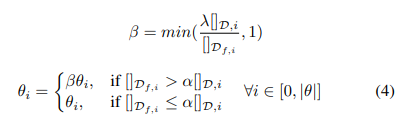

In [107]:
unlearning_model = ResNet18(num_classes = 20, pretrained = True).to('cuda')
unlearning_model.load_state_dict(torch.load("/kaggle/working/Resnet18_CIFAR100_5_Epochs.pt", map_location='cuda'))

<All keys matched successfully>

In [108]:
def update_weights_by_dampening_rule(unlearning_model, forget_fisher_diagonal, retain_fisher_diagonal, lambda_=1.0, alpha=10):
    total_weights = 0
    updated_weights = 0

    with torch.no_grad():
        for name, param in unlearning_model.named_parameters():
            forget_fisher = forget_fisher_diagonal.get(name)
            retain_fisher = retain_fisher_diagonal.get(name)
            
            if forget_fisher is None or retain_fisher is None:
                continue
            
            # Compute beta element-wise
            beta = torch.minimum((lambda_ * retain_fisher) / (forget_fisher + 1e-8), torch.ones_like(forget_fisher))

            # Create mask for where forget_fisher > alpha * retain_fisher
            mask = forget_fisher > (alpha * retain_fisher)

            # Count stats
            total_weights += param.numel()
            updated_weights += mask.sum().item()

            # Apply update rule: scale theta by beta where mask is True
            param.data[mask] = (beta[mask] * param.data[mask])

    fraction_updated = updated_weights / total_weights
    print(f"Fraction of weights scaled: {fraction_updated:.4f}")

    return fraction_updated

update_weights_by_dampening_rule(unlearning_model, forget_fisher_diagonal, retain_fisher_diagonal, lambda_=1.0, alpha=10)

Fraction of weights scaled: 0.0013


0.0012955479918603865

In [109]:
evaluate(unlearning_model,retain_test_dl,device) #Evaluating the Unlearnt model on retain test set (loss,accuracy)

(0.7479111705070887, 0.7918181818181819)

In [110]:
evaluate(unlearning_model,forget_test_dl,device) #Evaluating the Unlearnt model on forget test set (loss,accuracy)

(2.9994308948516846, 0.21)

#### Inferences:
- Fraction of weights zeroed out: 0.00129
- Retain Accuracy 0.79
- Forget Accuracy 0.21